In [1]:
from sklearn.decomposition import SparsePCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from librosa import core
import librosa
import librosa.display
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib
from IPython.display import display
from pandas.plotting import radviz
from pandas.plotting import andrews_curves
from IPython import display as dis

from pandas.plotting import parallel_coordinates
matplotlib.style.use('ggplot')
pd.set_option("display.max_rows",20)
from matplotlib import animation, rc


%matplotlib inline

In [2]:
x_y_first_hand_crafted = pd.read_pickle("dataset/x_y_first_hand_crafted.pkl")
x_y_sample_hand_crafted = pd.read_pickle("dataset/x_y_sample_hand_crafted.pkl")
x_y_sample_network_learned = pd.read_pickle("dataset/x_y_sample_network_learned.pkl")
x_y_sample_network_predictnext_learned = pd.read_pickle("dataset/x_y_sample_network_predictnext_learned.pkl")

x_y_sample_network_targetted_learned = pd.read_pickle("dataset/x_y_sample_network_targetted_learned.pkl")


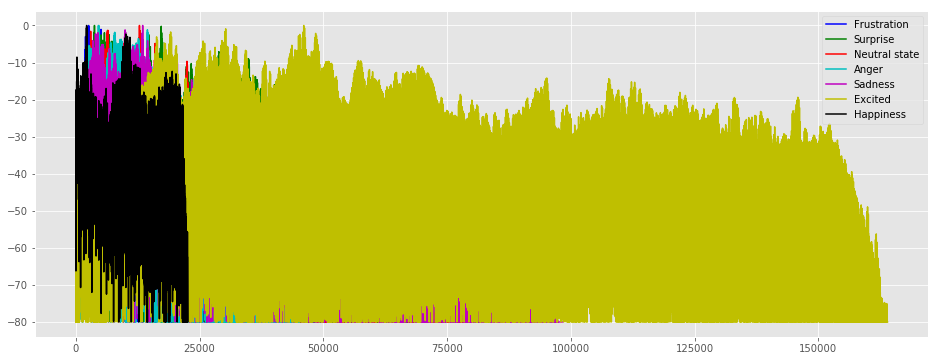

In [3]:
rate = 8000
color_codes = ['b','g','r','c','m','y','k']
legend_handles = []

plt.figure(figsize=[16,6])
for c, (index, series) in enumerate(x_y_first_hand_crafted.iterrows()):
    l_h, = plt.plot(series.mfcc.ravel(), color_codes[c], label = series.emotion )
    legend_handles.append(l_h)
plt.legend(handles=legend_handles)
#x_y_first_hand_crafted.spectral_bw[0]

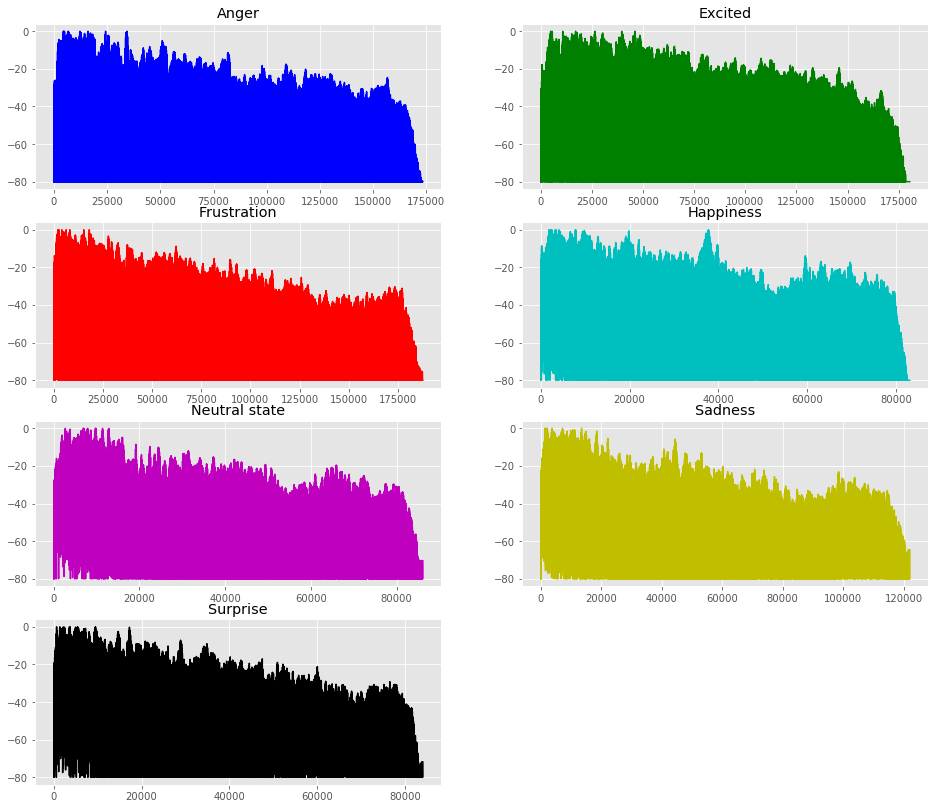

In [4]:
sub_plots = 1
x_y_last_grp = x_y_sample_hand_crafted.groupby(by='emotion')
plt.figure(figsize=[16,14])

for c, (name, group) in enumerate(x_y_last_grp):
    color_codes = ['b','g','r','c','m','y','k']
    plt.subplot(420+sub_plots)
    sub_plots += 1
    for index, series in group.iterrows():
        l_h, = plt.plot(series.mfcc.ravel(), color_codes[c], label = series.emotion )
        legend_handles.append(l_h)
    
    plt.title(name)
    #plt.legend(handles=legend_handles)

In [5]:
def plot_spec(y, sr = rate, plot_num = 1, emotion="", sub_plot=False, rows = 1, cols = 1):
    
    #if(sub_plot is False):
    #    plt.figure(plot_num+1, figsize=(12, 8))
    #else:
    ax = plt.subplot(rows, cols, plot_num)
    ax.get_yaxis().set_visible(False)
    #print(y.shape)
    # Visualize an STFT power spectrum
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    
    # Or on a logarithmic scale

    #print(D.shape)
    librosa.display.specshow(D, sr = rate, y_axis='log')
    #plt.colorbar(format='%+2.0f dB')
    plt.title(emotion)

    
def plot_spec_comb(y, sr = rate, plot_num = 1, emotion=""):

    plt.figure(plot_num)
    C = librosa.feature.chroma_cqt(y=y, sr=sr, n_chroma=5)
    tempo, beat_f = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    beat_f = librosa.util.fix_frames(beat_f, x_max=C.shape[1])
    Csync = librosa.util.sync(C, beat_f, aggregate=np.median)
    beat_t = librosa.frames_to_time(beat_f, sr=sr)
    ax1 = plt.subplot(2,1,1)
    librosa.display.specshow(C, y_axis='chroma', x_axis='time')
    plt.title('Chroma (linear time)')
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    librosa.display.specshow(Csync, y_axis='chroma', x_axis='time',
                             x_coords=beat_t)
    plt.title('Chroma (beat time)')
    plt.tight_layout()


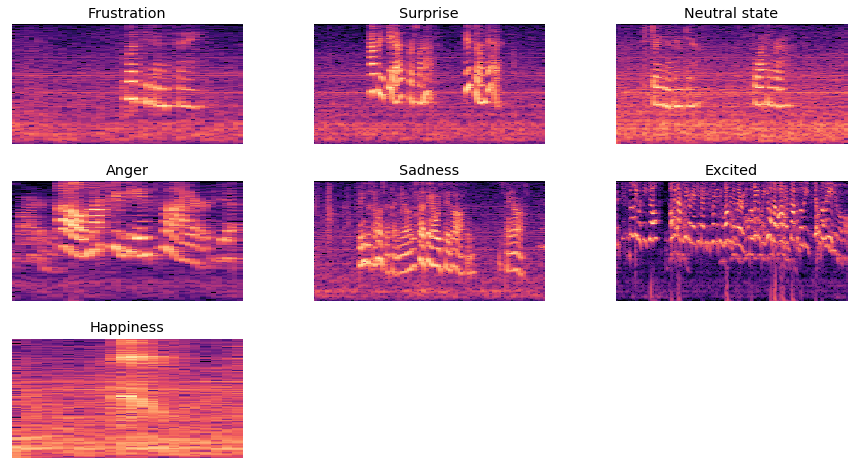

In [6]:
fig = plt.figure(figsize=(15, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.title("'Log Frequency: Power spectrogram '")
for count, (index, series) in enumerate(x_y_first_hand_crafted.iterrows()):
    plot_spec(series.sigs.ravel(),plot_num = count+1, emotion=series.emotion, rows = 3, cols =3)
fig.savefig('onesampleofeach.png', dpi=100)

In [7]:
#for count, (index, series) in enumerate(x_y_first.iterrows()):
#    plot_spec_comb(series.sigs.ravel(),plot_num = count+1, emotion=index)

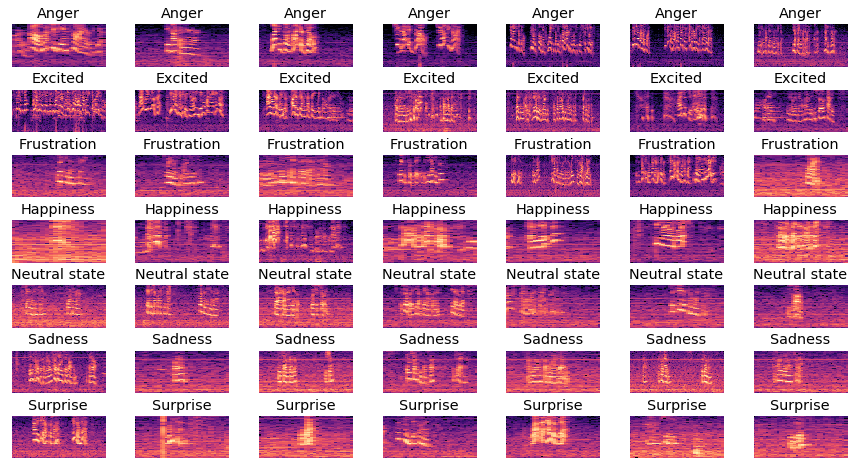

In [8]:
fig = plt.figure(figsize=(15, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.title("'Log Frequency: Power spectrogram '")
c = 1
for m, (name, group) in enumerate(x_y_last_grp):
    for n, (index, series) in enumerate(group.iterrows()):
        plot_spec(series.sigs.ravel(),plot_num = c, emotion=name, rows = 7, cols = 7)
        c+=1
        

In [9]:
def feature_proximity_tsne(df, col, groupby, name='animation.gif'):
    mfcc_first = np.array(df.loc[:,col].values)

    mfcc_first_max = max([ m_f.ravel().reshape(1,-1).shape[1] for m_f in mfcc_first])
    mfcc_first_min = min([ m_f.ravel().reshape(1,-1).shape[1] for m_f in mfcc_first])
    
    #if mfcc_first_max == 1:
    #    mfcc_first_max = max([ m_f.ravel().reshape(1,-1).shape[0] for m_f in mfcc_first])
    #    mfcc_first_min = min([ m_f.ravel().reshape(1,-1).shape[0] for m_f in mfcc_first])
    
    
    print("min, max:",mfcc_first_min, mfcc_first_max)
    
    
    pca_analysis = KernelPCA(n_components=mfcc_first_min, kernel='rbf', gamma=10, remove_zero_eig=True)
    mfcc_pca = []
    #print(mfcc_first.shape)
    for c, m_f in enumerate(mfcc_first):
        if(len(m_f.shape) < 2):
            m_f = m_f.ravel().reshape(1,-1)
        else:
            m_f = m_f.ravel().reshape(1,-1)
        
        #print("entering", m_f.shape)
        #print( np.zeros((1, mfcc_first_max - m_f.shape[1])).shape)
        m_f = np.concatenate((m_f, np.zeros((1, mfcc_first_max - m_f.shape[1]))), axis=1)
        mfcc_first[c] = m_f
        #print("after", m_f.shape)
    
    mfcc_first = np.concatenate(mfcc_first, axis=0)
    print("before_pca", mfcc_first.shape)
    mfcc_pca = pca_analysis.fit_transform(mfcc_first)
    print("completed pca",mfcc_pca.shape)
    #plt.imshow(mfcc_pca)
    fig, ax = plt.subplots(figsize=[10,6])
    
    def tsne_fn(i):
        model = TSNE(n_components=2, random_state=0, n_iter=i)
        mfcc_tsne = model.fit_transform(mfcc_pca)
        #mfcc_tsne = (mfcc_tsne - mfcc_tsne.mean()) / mfcc_tsne.std()
        #print(mfcc_tsne)
        
        df.loc[:,"tsne_x"] = mfcc_tsne[:,0]
        df.loc[:,"tsne_y"] = mfcc_tsne[:,1]
        df_grp = df.groupby(by=groupby)
        
        return df_grp
    
    def init():
        for c, (name, group) in enumerate(df_grp):
            p = ax.scatter(x=group.loc[:,"tsne_x"].values, y=group.loc[:,"tsne_y"].values, c=color_codes[c], label=name)
        return p
    
    df_grp = tsne_fn(250)
    p = init()
    ax.legend(loc=1)
    fig, ax = plt.subplots(figsize=[10,6])
    df_grp = tsne_fn(750)
    p = init()
    ax.legend(loc=1)
    
    fig, ax = plt.subplots(figsize=[10,6])
    df_grp = tsne_fn(1250)
    p = init()
    ax.legend(loc=1)
    
    fig, ax = plt.subplots(figsize=[10,6])
    df_grp = tsne_fn(1750)
    p = init()
    ax.legend(loc=1)
    
    fig, ax = plt.subplots(figsize=[10,6])
    df_grp = tsne_fn(2250)
    p = init()
    ax.legend(loc=1)
    
    fig, ax = plt.subplots(figsize=[10,6])
    df_grp = tsne_fn(2500)
    p = init()
    ax.legend(loc=1)
    
    def animate_gen():
        for i in range(250, 1000, 50):
            df_grp = tsne_fn(i)
            for c, (name, group) in enumerate(df_grp):
                
                #p.set_xdata(group.loc[:,"tsne_x"].values)
                yield (c, (name, group))
        
    def animate(tpl):
        c, (name, group) = tpl
        p.set_offsets((group.loc[:,"tsne_x"].values,group.loc[:,"tsne_y"].values))
        p.set_facecolors(color_codes[c])
        return p
        
        
    anim = animation.FuncAnimation(fig, animate, 
                               frames=animate_gen(), interval=1, blit=False, repeat = False)
    
    #print(anim.to_html5_video())
    anim.save(name, writer='imagemagick', fps=1)
    #plt.show()   
    return mfcc_pca, df, df_grp
    
def feature_proximity_pc(mfcc_pca, df, df_grp):
    df_p = pd.DataFrame(mfcc_pca)
    df_p.loc[:,"emotion"] = df.loc[:,"emotion"].values
    print(df_p.shape)
    print(df_p.columns)
    plt.figure(figsize=[10,6])
    andrews_curves(df_p, "emotion")
    plt.figure(figsize=[10,6])
    radviz(df_p, "emotion")


min, max: 22550 164000
before_pca (7, 164000)
completed pca (7, 7)


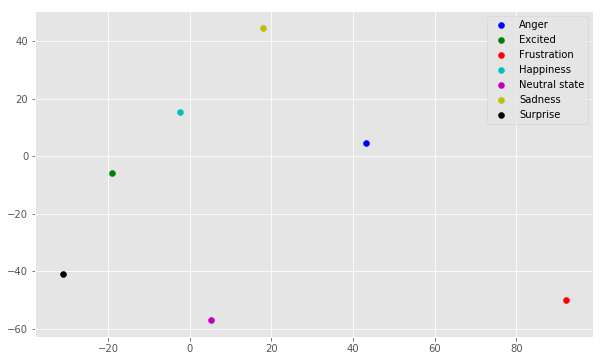

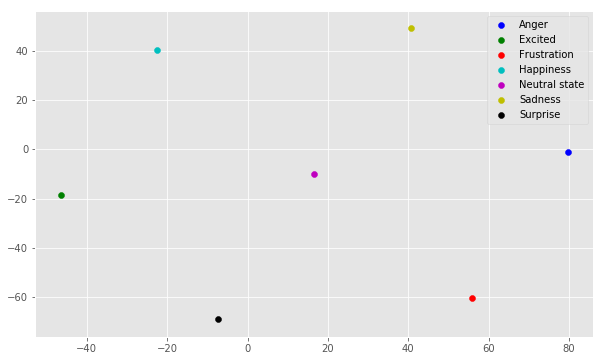

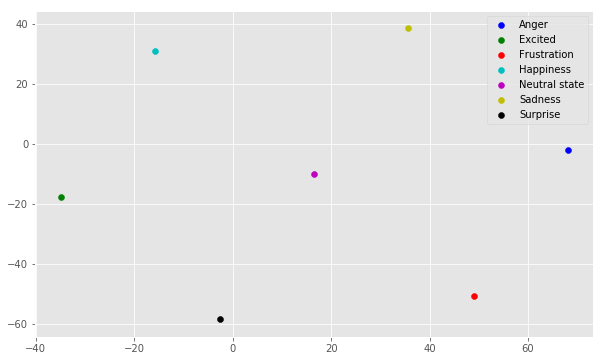

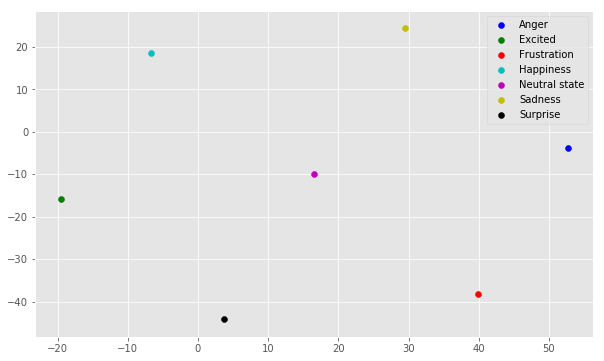

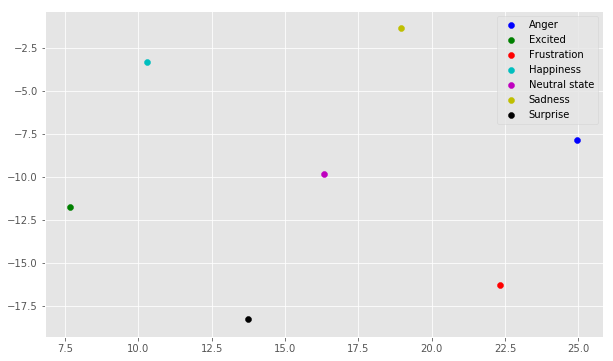

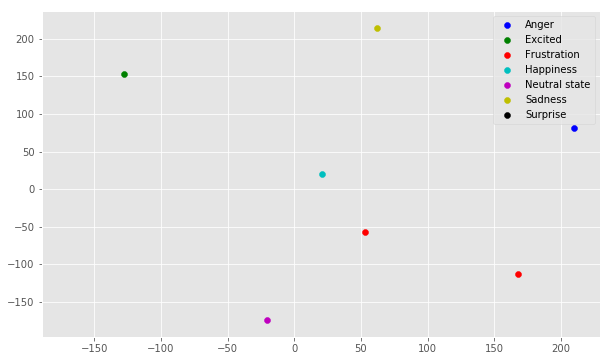

In [10]:
mfcc_pca, df, df_grp = feature_proximity_tsne(x_y_first_hand_crafted, "mfcc", "emotion", "oneeach_mfcc.gif")

(7, 8)
Index([0, 1, 2, 3, 4, 5, 6, 'emotion'], dtype='object')


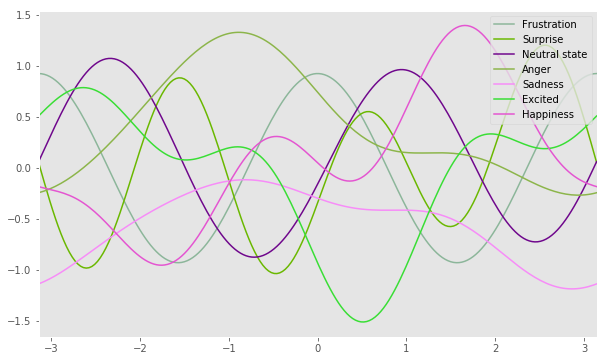

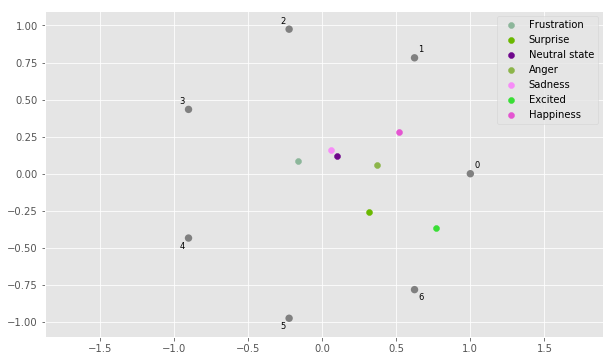

In [11]:
feature_proximity_pc(mfcc_pca, df, df_grp)

min, max: 22 160
before_pca (7, 160)
completed pca (7, 7)


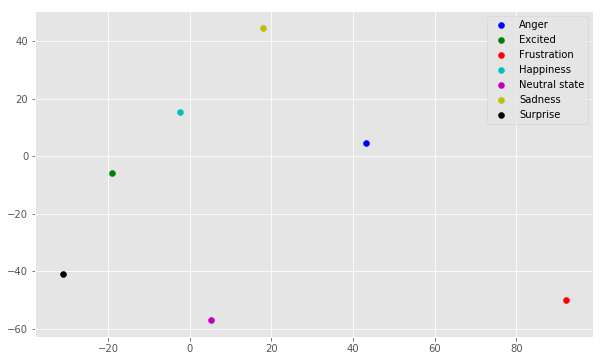

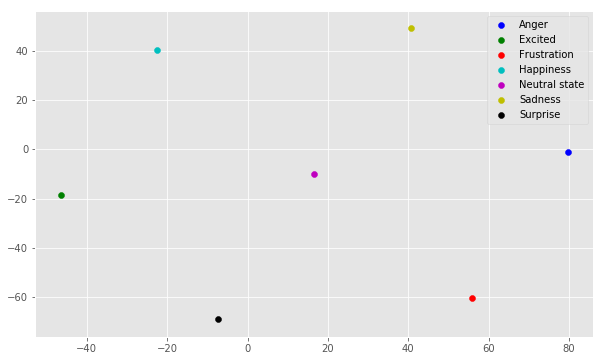

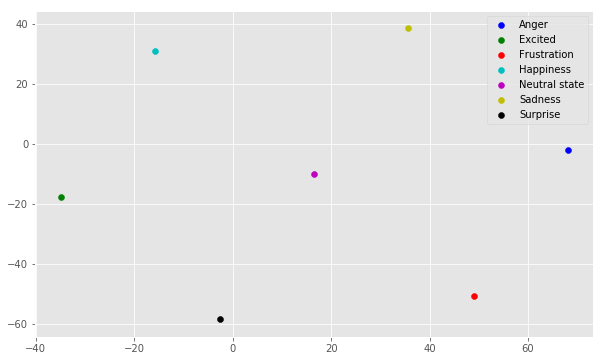

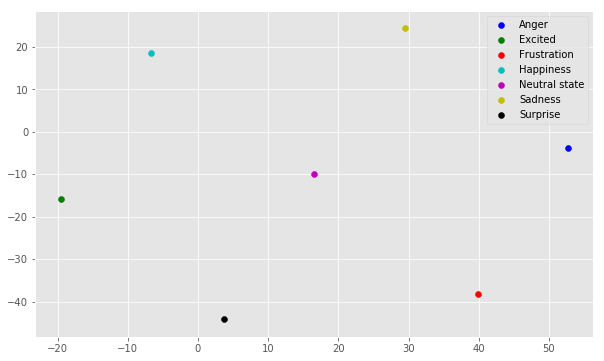

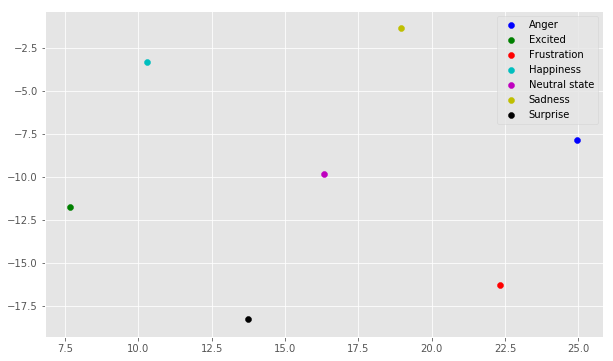

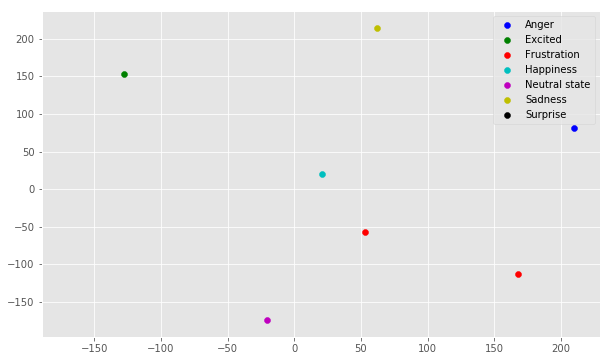

In [12]:
mfcc_pca, df, df_grp = feature_proximity_tsne(x_y_first_hand_crafted, "spectral_bw", "emotion", "oneeach_sbw.gif")

(7, 8)
Index([0, 1, 2, 3, 4, 5, 6, 'emotion'], dtype='object')


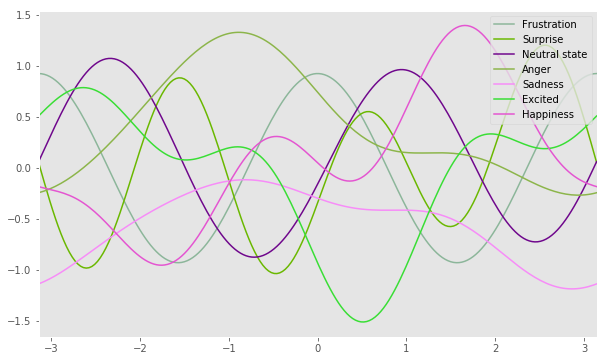

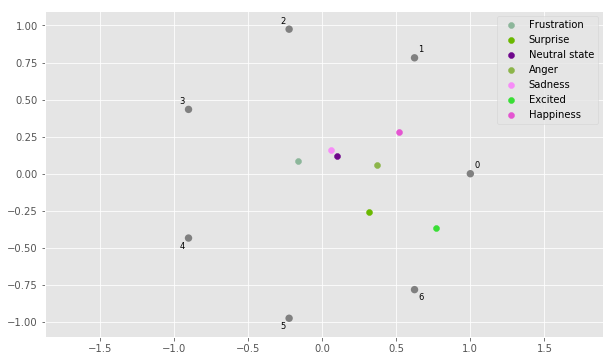

In [13]:
feature_proximity_pc(mfcc_pca, df, df_grp)

min, max: 22550 187575
before_pca (49, 187575)
completed pca (49, 49)


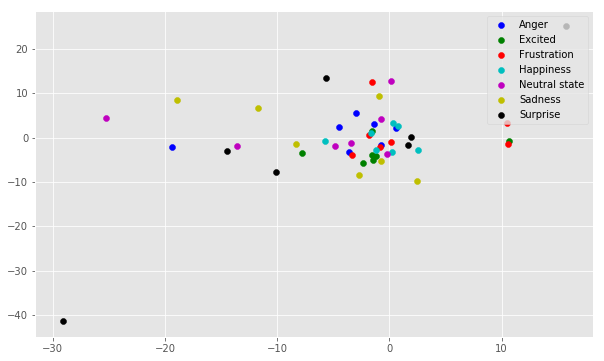

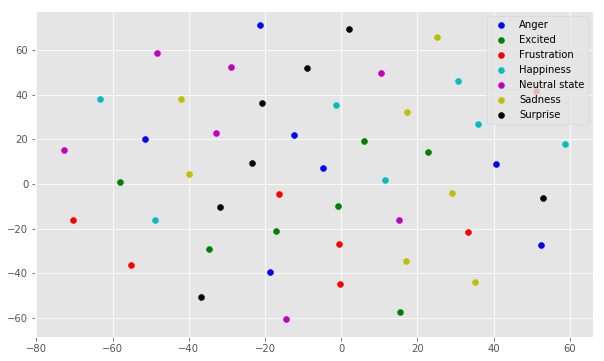

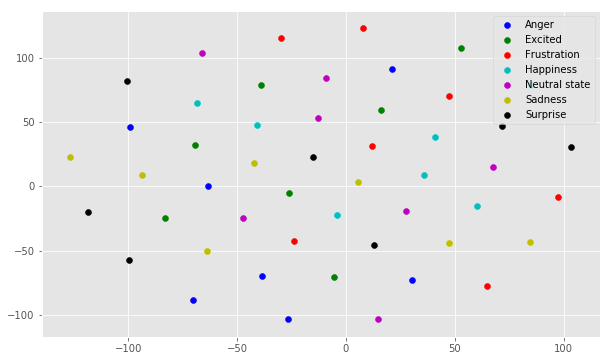

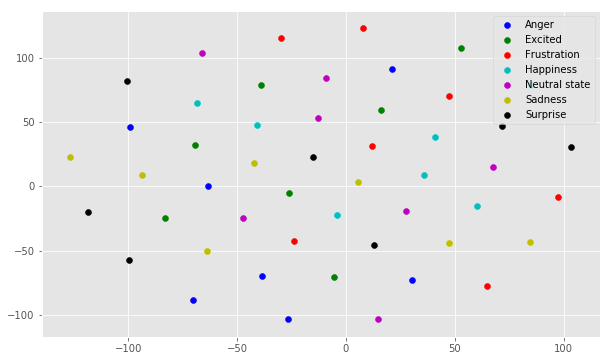

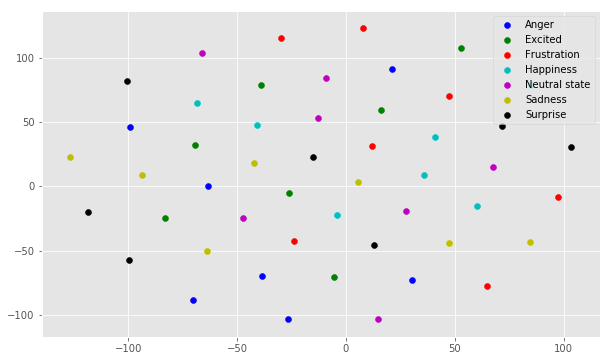

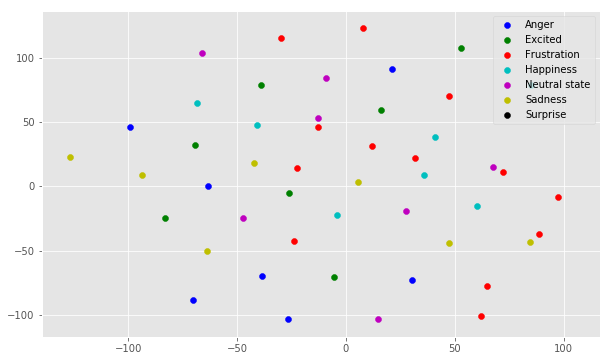

In [14]:
mfcc_pca, df, df_grp = feature_proximity_tsne(x_y_sample_hand_crafted, "mfcc", "emotion", "all_mfcc.gif")

(49, 50)
Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39,        40,        41,
              42,        43,        44,        45,        46,        47,
              48, 'emotion'],
      dtype='object')


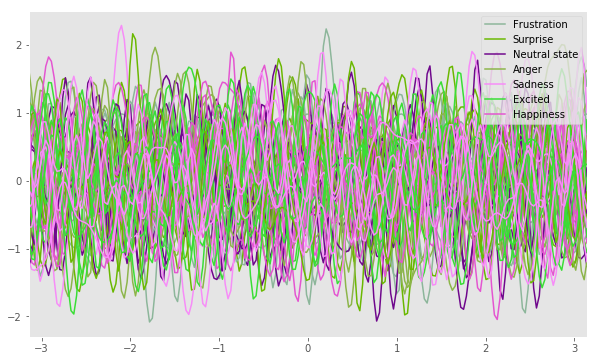

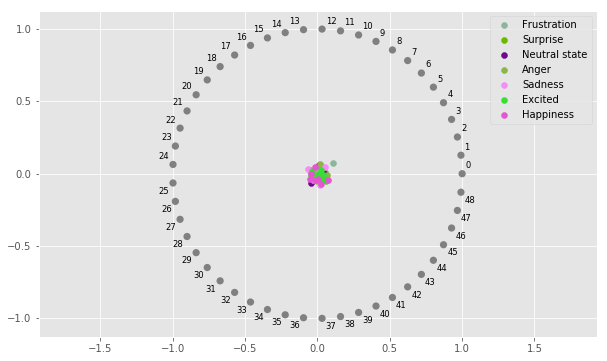

In [15]:
feature_proximity_pc(mfcc_pca, df, df_grp)

min, max: 22 183
before_pca (49, 183)
completed pca (49, 22)


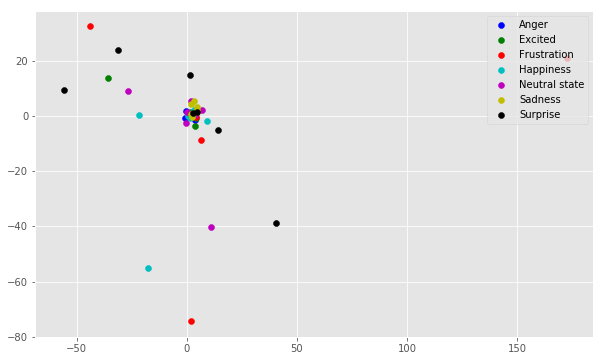

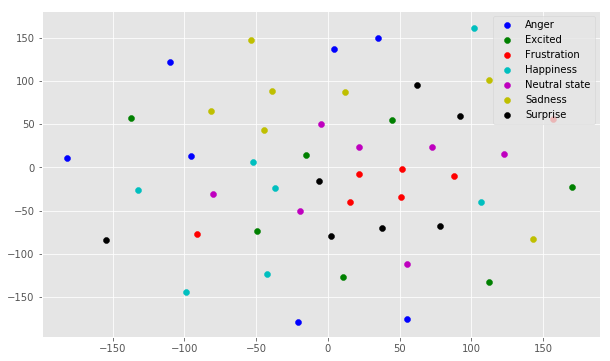

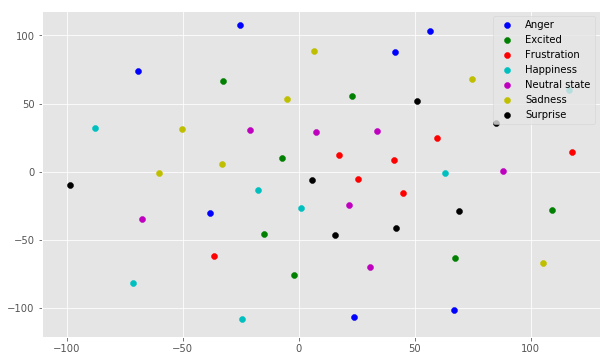

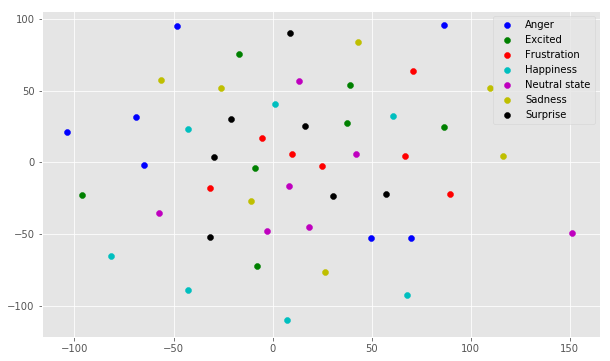

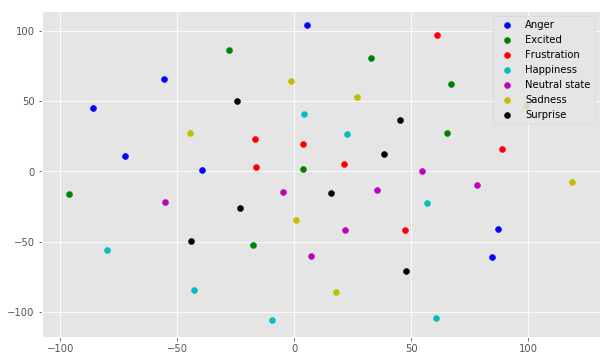

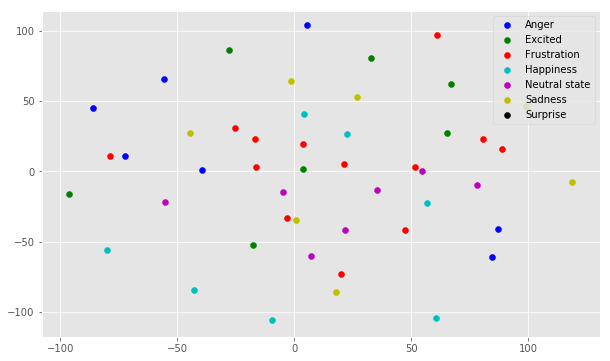

In [16]:
mfcc_pca, df, df_grp = feature_proximity_tsne(x_y_sample_hand_crafted, "spectral_bw", "emotion", "all_sbw.gif")

(49, 23)
Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21, 'emotion'],
      dtype='object')


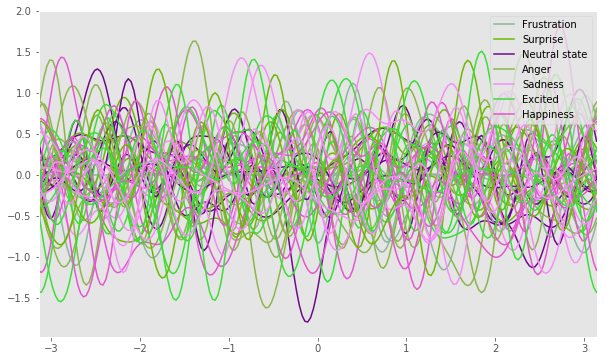

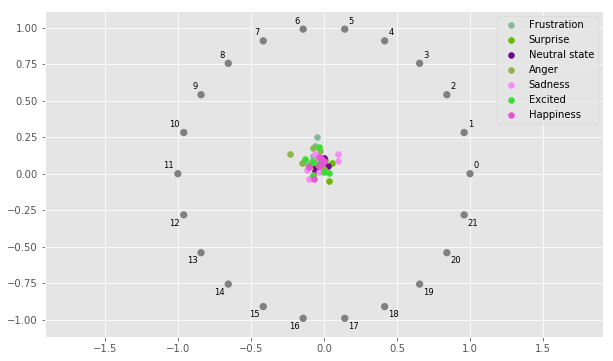

In [17]:
feature_proximity_pc(mfcc_pca, df, df_grp)

min, max: 61 61
before_pca (1000, 61)
completed pca (1000, 61)


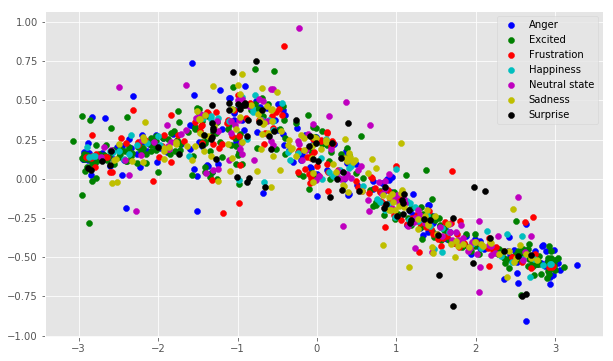

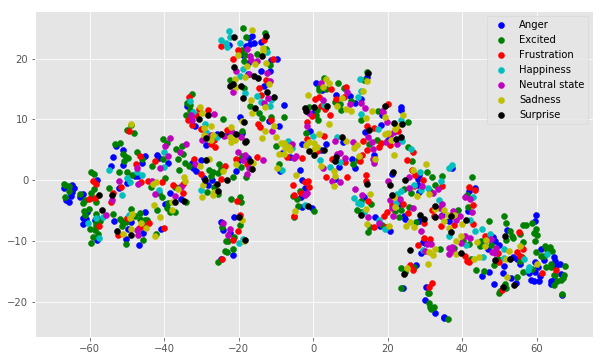

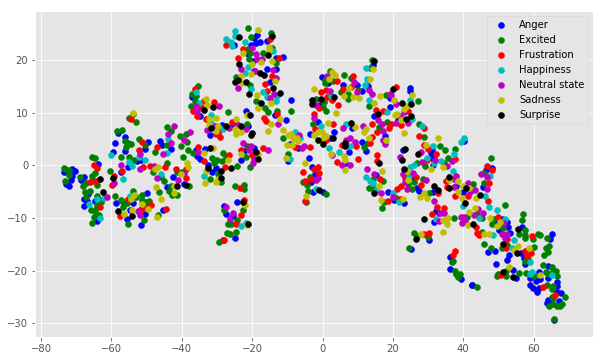

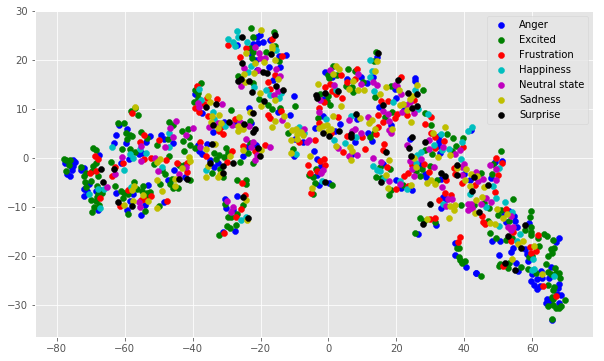

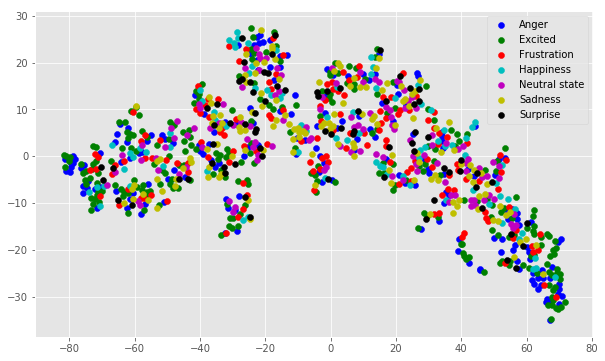

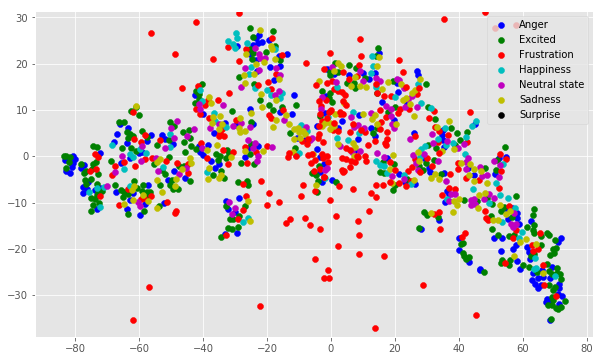

In [18]:
#feature_proximity_tsne(x_y_sample_network_learned, "state_h", "emotion")
mfcc_pca, df, df_grp = feature_proximity_tsne(x_y_sample_network_learned, "state_c", "emotion", "all_feature_learned.gif")

(1000, 62)
Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39,        40,        41,
              42,        43,        44,        45,        46,        47,
              48,        49,        50,        51,        52,        53,
              54,        55,        56,        57,        58,        59,
              60, 'emotion'],
      dtype='object')


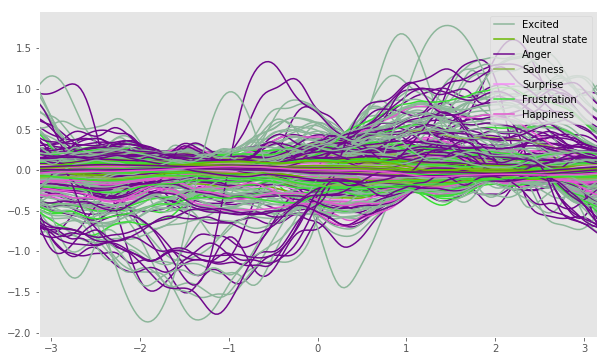

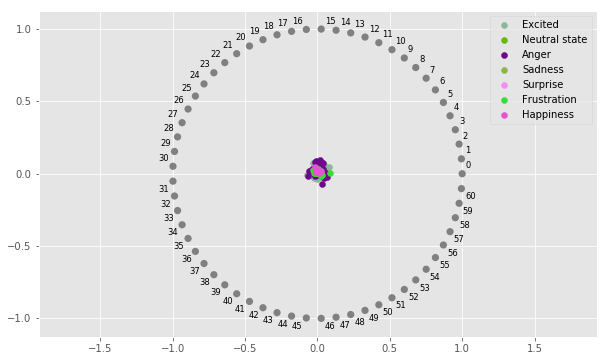

In [19]:
feature_proximity_pc(mfcc_pca, df, df_grp)

In [20]:
#feature_proximity_pc(x_y_sample_network_learned, "state_h", "emotion")
#feature_proximity_pc(x_y_sample_network_learned, "state_c", "emotion")

min, max: 61 61
before_pca (1000, 61)
completed pca (1000, 61)


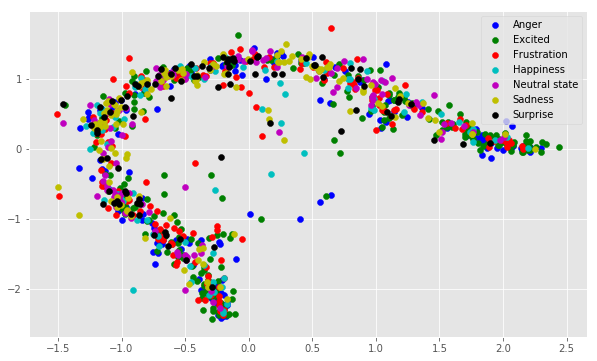

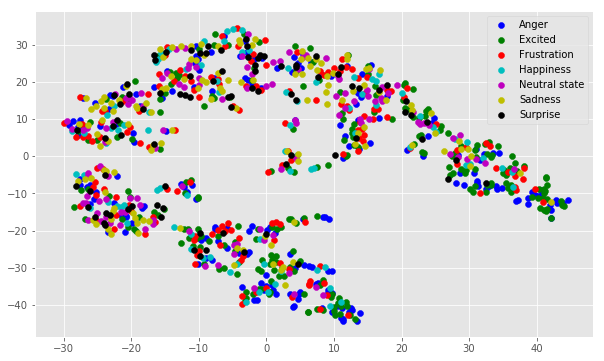

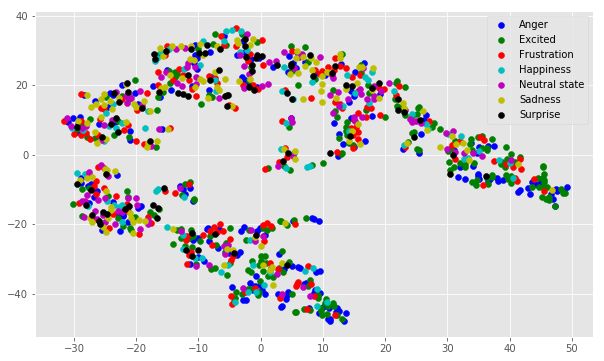

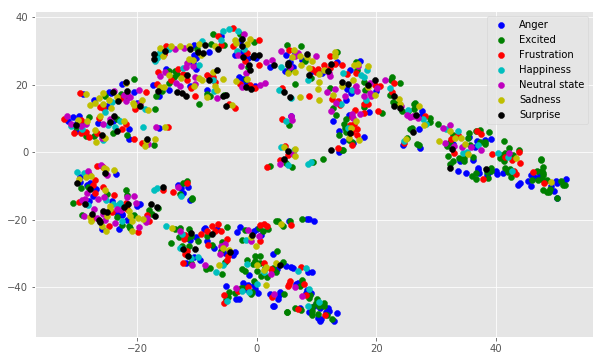

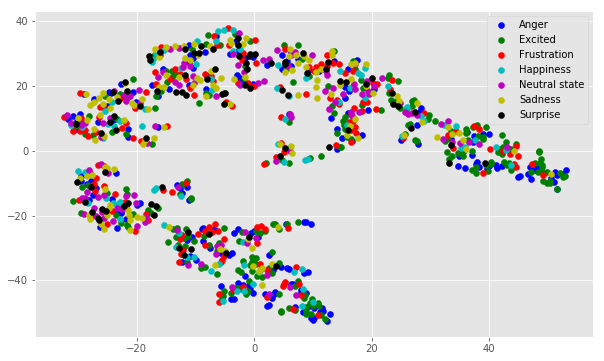

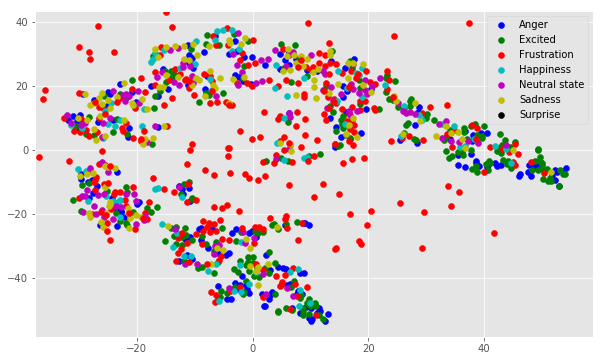

In [21]:
mfcc_pca, df, df_grp = feature_proximity_tsne(x_y_sample_network_predictnext_learned, "state_c", "emotion", "all_feature_predictnext_learned.gif")

(1000, 62)
Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39,        40,        41,
              42,        43,        44,        45,        46,        47,
              48,        49,        50,        51,        52,        53,
              54,        55,        56,        57,        58,        59,
              60, 'emotion'],
      dtype='object')


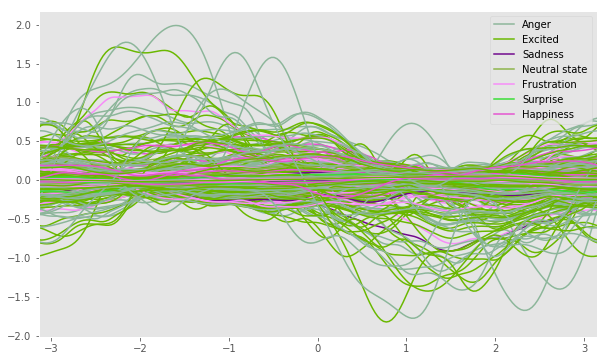

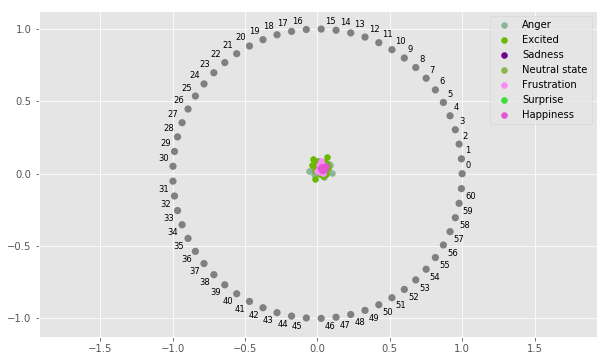

In [22]:
feature_proximity_pc(mfcc_pca, df, df_grp)

min, max: 40 40
before_pca (1000, 40)
completed pca (1000, 40)


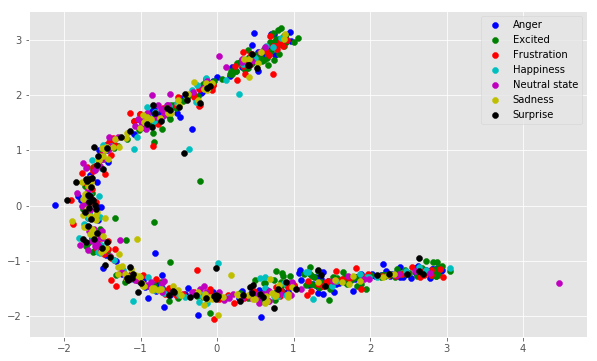

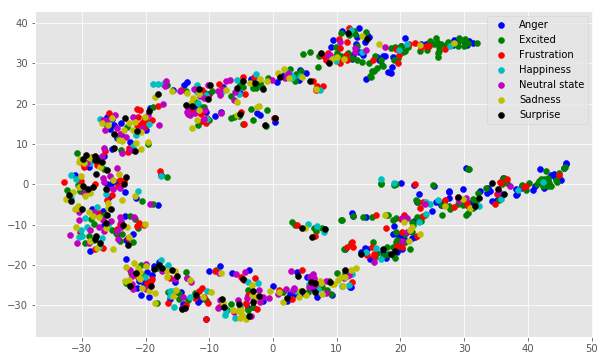

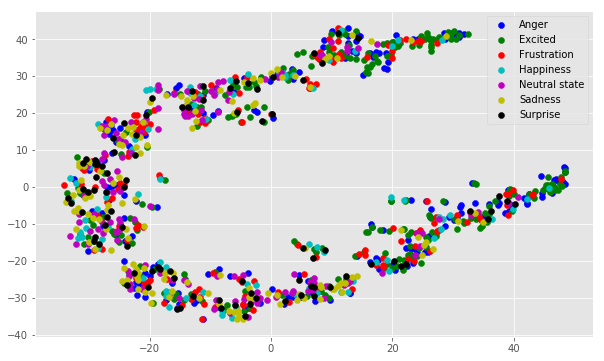

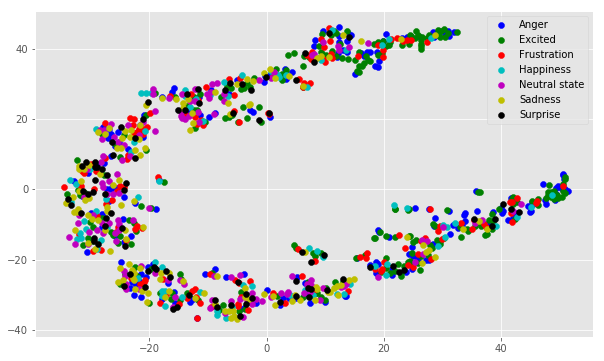

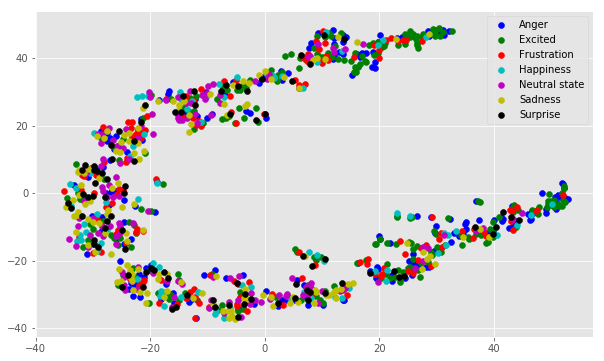

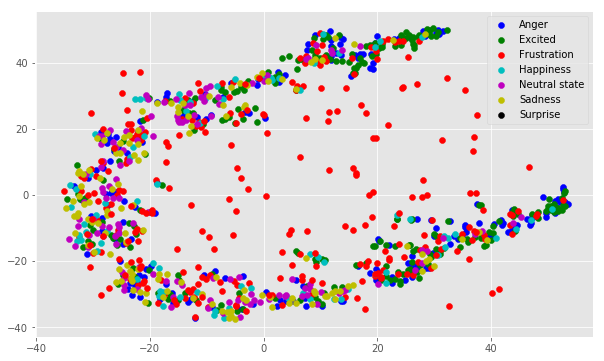

In [23]:
mfcc_pca, df, df_grp = feature_proximity_tsne(x_y_sample_network_targetted_learned, "hidden", "emotion", "all_feature_targeted_learned.gif")

(1000, 41)
Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39, 'emotion'],
      dtype='object')


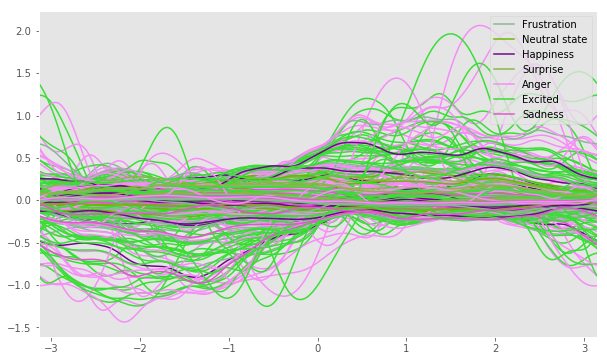

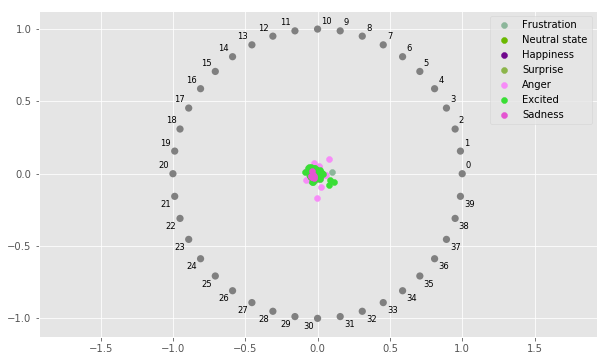

In [24]:
feature_proximity_pc(mfcc_pca, df, df_grp)

In [25]:
def feature_proximity_comp_tsne(dfs, cols, cats):
    
    df_m = []
    for c, df in enumerate(dfs):
        print(c)
        df.loc[:,"cat"] = cats[c]
        df = df.rename(columns={cols[c]:"feature"})
        df = df.loc[:,["feature", "cat"]]
        
        if(len(df.feature.values[0].shape) < 2):
            for _, row in df.iterrows():
                row.feature = row.feature / np.max(row.feature)
                row.feature = row.feature.reshape(1,-1)
        #df.feature = (df.feature - np.mean(df.feature.values))/np.std(df.feature.values)

        df_m.append(df)
               
    df = pd.concat(df_m, axis = 0)
    
    display(df)
    
    mfcc_first = np.array(df.feature.values)
    mfcc_first_min = min([ m_f.ravel().reshape(1,-1).shape[1] for m_f in mfcc_first])
    mfcc_first_max = max([ m_f.ravel().reshape(1,-1).shape[1] for m_f in mfcc_first])
    
    print("min, max:",mfcc_first_min, mfcc_first_max)
    pca_analysis = KernelPCA(n_components=mfcc_first_min, kernel='rbf')
       
    for c, m_f in enumerate(mfcc_first):
        m_f = np.concatenate((m_f.ravel().reshape(1,-1), np.zeros((1, mfcc_first_max - m_f.ravel().reshape(1,-1).shape[1]))), axis=1)
        mfcc_first[c] = m_f.ravel().reshape(1,-1)
        #print(m_f.ravel().reshape(1,-1).shape)
        
    mfcc_first = np.concatenate(mfcc_first)
    print("entering pca:", mfcc_first.shape)
    #mfcc_first = (mfcc_first - np.mean(mfcc_first))/np.std(mfcc_first)
    
    mfcc_pca = pca_analysis.fit_transform(mfcc_first)
    
    print("after pca:", mfcc_pca.shape)
    
    
    #plt.imshow(mfcc_pca)
    def tsne_plot(i):
        model = TSNE(n_components=2, random_state=0,n_iter=i)
        mfcc_tsne = model.fit_transform(mfcc_pca)
        #mfcc_tsne = (mfcc_tsne - mfcc_tsne.mean()) / mfcc_tsne.std()
        #print(mfcc_tsne)

        df.loc[:,"tsne_x"] = mfcc_tsne[:,0]
        df.loc[:,"tsne_y"] = mfcc_tsne[:,1]

        df_grp = df.groupby(by="cat")
        

        for c, (name, group) in enumerate(df_grp):
            ax.scatter(x=group.loc[:,"tsne_x"].values, y=group.loc[:,"tsne_y"].values, c=color_codes[c], label=name)
            
    fig, ax = plt.subplots(figsize=[10,6])
    tsne_plot(250)
    ax.legend()
    fig, ax = plt.subplots(figsize=[10,6])
    tsne_plot(500)
    ax.legend()
    fig, ax = plt.subplots(figsize=[10,6])
    tsne_plot(750)
    ax.legend()
    fig, ax = plt.subplots(figsize=[10,6])
    tsne_plot(1000)
    ax.legend()
    fig, ax = plt.subplots(figsize=[10,6])
    tsne_plot(1250)
    ax.legend()
    fig, ax = plt.subplots(figsize=[10,6])
    tsne_plot(1500)
    ax.legend()
    
    return mfcc_pca, df, df_grp

def feature_proximity_comb_pc(mfcc_pca, df, df_grp):
    df_p = pd.DataFrame(mfcc_pca)
    df_p.loc[:,"cat"] = df.loc[:,"cat"].values
    display(df_p)
    plt.figure(figsize=[10,6])
    andrews_curves(df_p, "cat")
    plt.figure(figsize=[10,6])
    radviz(df_p, "cat")
    

0
1
2
3
4


feature  \
Ses01F_script01_1_F000  [[1001.45881254, 986.238267126, 969.779610065,...   
Ses01F_script01_1_F002  [[916.352082794, 923.138043189, 920.995299453,...   
Ses01F_script01_1_F003  [[918.380956056, 899.40610052, 878.872961585, ...   
Ses01F_script01_1_F005  [[884.918946018, 893.554716114, 901.514645952,...   
Ses01F_script01_1_F006  [[927.512063182, 905.566976771, 884.589868508,...   
Ses01F_script01_1_F007  [[923.983882354, 902.570780339, 861.79240638, ...   
Ses01F_script01_1_F008  [[693.983854839, 727.712793004, 849.894510655,...   
Ses01F_script01_1_F009  [[884.365254748, 886.7383852, 873.072811751, 8...   
Ses01F_script01_1_F010  [[834.061950037, 804.761958512, 905.374608997,...   
Ses01F_script01_1_F011  [[894.269250819, 889.45225734, 878.3556761, 89...   
...                                                                   ...   
(21.0, 5.0)             [[-0.239925, 0.586654, 0.338875, 0.497245, 0.7...   
(38.0, 29.0)            [[-0.230903, 0.609276, 0.315566, 0.52438, 0.79...   
(31.0, 10.0)            [[-0.242955, 0.585178, 0.341413, 0.493946, 0.7...   
(13.0, 34.0)            [[-0.23926, 0.587416, 0.338069, 0.49836, 0.722...   
(37.0, 13.0)            [[-0.243475, 0.56859, 0.359759, 0.483048, 0.67...   
(38.0, 41.0)            [[-0.195465, 0.636241, 0.305701, 0.570221, 0.9...   
(42.0, 46.0)            [[-0.242274, 0.582664, 0.340247, 0.492248, 0.7...   
(38.0, 21.0)            [[-0.241607, 0.583097, 0.339623, 0.493081, 0.7...   
(29.0, 6.0)             [[-0.259593, 0.560365, 0.344921, 0.462027, 0.6...   
(28.0, 52.0)            [[-0.238669, 0.583458, 0.337954, 0.495585, 0.7...   

                                               cat  
Ses01F_script01_1_F000       Hand Crafted-Spectral  
Ses01F_script01_1_F002       Hand Crafted-Spectral  
Ses01F_script01_1_F003       Hand Crafted-Spectral  
Ses01F_script01_1_F005       Hand Crafted-Spectral  
Ses01F_script01_1_F006       Hand Crafted-Spectral  
Ses01F_script01_1_F007       Hand Crafted-Spectral  
Ses01F_script01_1_F008       Hand Crafted-Spectral  
Ses01F_script01_1_F009       Hand Crafted-Spectral  
Ses01F_script01_1_F010       Hand Crafted-Spectral  
Ses01F_script01_1_F011       Hand Crafted-Spectral  
...                                            ...  
(21.0, 5.0)             Autoencoder and Classifier  
(38.0, 29.0)            Autoencoder and Classifier  
(31.0, 10.0)            Autoencoder and Classifier  
(13.0, 34.0)            Autoencoder and Classifier  
(37.0, 13.0)            Autoencoder and Classifier  
(38.0, 41.0)            Autoencoder and Classifier  
(42.0, 46.0)            Autoencoder and Classifier  
(38.0, 21.0)            Autoencoder and Classifier  
(29.0, 6.0)             Autoencoder and Classifier  
(28.0, 52.0)            Autoencoder and Classifier  

[3098 rows x 2 columns]

min, max: 22 187575
entering pca: (3098, 187575)
after pca: (3098, 22)


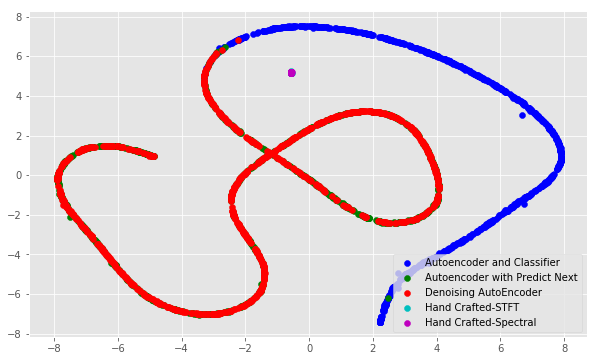

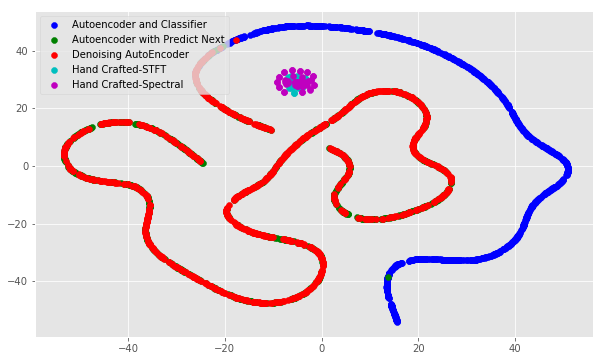

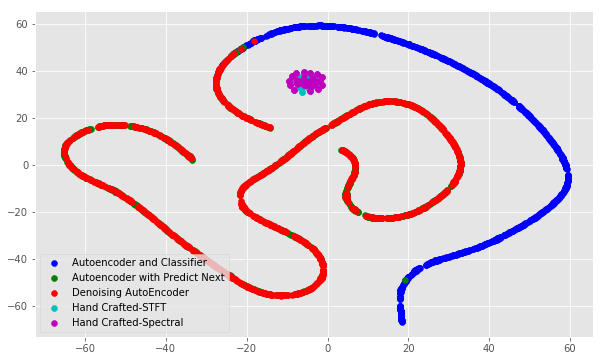

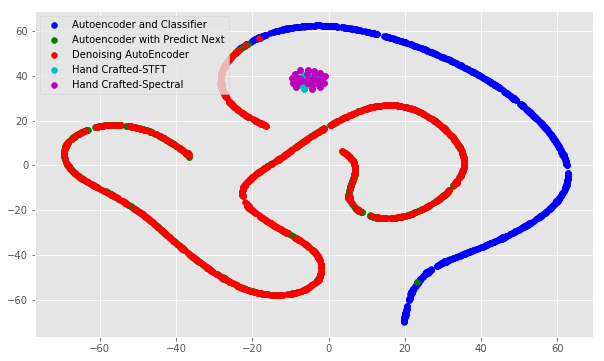

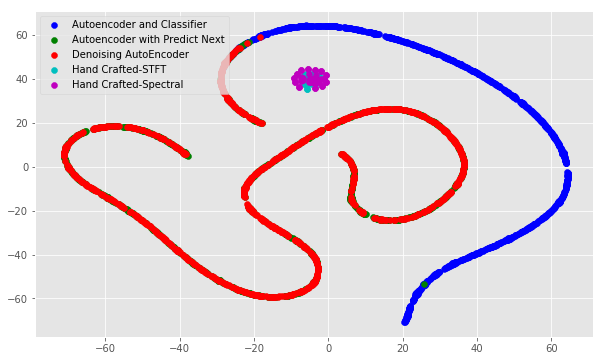

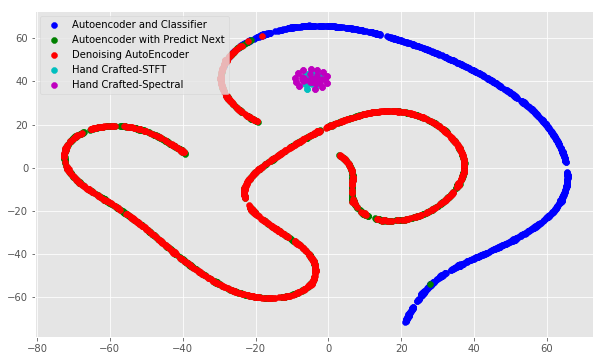

In [26]:
mfcc_pca, df, df_grp = feature_proximity_comp_tsne((x_y_sample_hand_crafted, x_y_sample_hand_crafted, x_y_sample_network_learned, x_y_sample_network_predictnext_learned, x_y_sample_network_targetted_learned),
                       ("spectral_bw", "mfcc", "state_c", "state_c", "hidden"), 
                       ("Hand Crafted-Spectral", "Hand Crafted-STFT", "Denoising AutoEncoder", "Autoencoder with Predict Next", "Autoencoder and Classifier"))

0             1             2             3             4  \
0    -0.973685 -2.610882e-02  7.147825e-01  9.250177e-03 -9.531948e-03   
1    -0.973199 -1.526981e-02 -1.512913e-02 -1.299460e-02  1.646292e-02   
2    -0.973370 -1.767224e-02 -2.388748e-02 -1.220739e-01 -6.921484e-01   
3    -0.973199 -1.526963e-02 -1.512869e-02 -1.299368e-02  1.646158e-02   
4    -0.973199 -1.526963e-02 -1.512869e-02 -1.299368e-02  1.646158e-02   
5    -0.973199 -1.527002e-02 -1.512967e-02 -1.299573e-02  1.646456e-02   
6    -0.973279 -1.641863e-02 -1.396482e-02 -2.177211e-02  3.087159e-02   
7    -0.973206 -1.541966e-02 -4.999537e-03 -1.268433e-02  1.610032e-02   
8    -0.974392  7.378116e-01  1.037788e-02  2.952419e-03 -2.895662e-03   
9    -0.973200 -1.528238e-02 -1.516023e-02 -1.306003e-02  1.655809e-02   
...        ...           ...           ...           ...           ...   
3088  0.031826  6.333382e-07  2.533440e-07  8.936961e-08 -9.872061e-08   
3089  0.031824  6.304472e-07  2.521258e-07  8.893064e-08 -9.823479e-08   
3090  0.031826  6.333880e-07  2.533649e-07  8.937714e-08 -9.872895e-08   
3091  0.031826  6.332266e-07  2.532970e-07  8.935267e-08 -9.870187e-08   
3092  0.031827  6.338736e-07  2.535690e-07  8.945058e-08 -9.881022e-08   
3093  0.031820  6.241497e-07  2.494707e-07  8.797367e-08 -9.717563e-08   
3094  0.031827  6.341160e-07  2.536716e-07  8.948764e-08 -9.885124e-08   
3095  0.031827  6.340656e-07  2.536504e-07  8.947999e-08 -9.884278e-08   
3096  0.031829  6.377499e-07  2.552016e-07  9.003873e-08 -9.946113e-08   
3097  0.031827  6.339904e-07  2.536187e-07  8.946858e-08 -9.883015e-08   

                 5             6             7             8             9  \
0     7.804123e-03 -3.847560e-03  1.755926e-04 -1.515742e-04  1.296870e-04   
1    -1.999309e-02 -1.790154e-02 -1.704660e-02  2.000566e-02 -2.095887e-02   
2     5.065572e-02  1.519746e-02  4.343919e-04 -3.979563e-04  3.746653e-04   
3    -1.999086e-02 -1.789839e-02 -1.680282e-02  1.884854e-02 -1.868664e-02   
4    -1.999086e-02 -1.789839e-02 -1.680313e-02  1.885000e-02 -1.868951e-02   
5    -1.999581e-02 -1.790540e-02 -1.735482e-02  2.163072e-02 -2.462319e-02   
6    -5.612912e-02  6.992302e-01  2.061314e-04 -6.112208e-05  3.429424e-05   
7    -1.960756e-02 -1.750372e-02 -1.586465e-02  1.577441e-02 -1.381563e-02   
8     2.869061e-03  1.769152e-03  3.150199e-04 -1.581047e-04  9.578714e-05   
9    -2.015157e-02 -1.812687e-02  6.986774e-01 -6.031978e-03  2.793482e-03   
...            ...           ...           ...           ...           ...   
3088  8.765448e-08  4.968142e-08  5.743276e-10 -1.592683e-10  8.422985e-11   
3089  8.722161e-08  4.943521e-08  5.714643e-10 -1.584742e-10  8.380985e-11   
3090  8.766192e-08  4.968565e-08  5.743767e-10 -1.592819e-10  8.423703e-11   
3091  8.763779e-08  4.967193e-08  5.742172e-10 -1.592377e-10  8.421365e-11   
3092  8.773431e-08  4.972682e-08  5.748553e-10 -1.594146e-10  8.430725e-11   
3093  8.627784e-08  4.889839e-08  5.652208e-10 -1.567427e-10  8.289414e-11   
3094  8.777087e-08  4.974762e-08  5.750974e-10 -1.594818e-10  8.434275e-11   
3095  8.776334e-08  4.974333e-08  5.750476e-10 -1.594679e-10  8.433545e-11   
3096  8.831427e-08  5.005667e-08  5.786912e-10 -1.604784e-10  8.486983e-11   
3097  8.775208e-08  4.973693e-08  5.749732e-10 -1.594473e-10  8.432452e-11   

                 ...                        13            14            15  \
0                ...              5.399246e-09  1.880243e-09  4.567746e-10   
1                ...              7.374515e-06  6.443966e-06  5.815898e-06   
2                ...              6.202960e-08  2.162396e-08  5.259311e-09   
3                ...             -2.021348e-02 -2.120964e-02 -2.069378e-02   
4                ...             -2.019918e-02 -2.121259e-02 -2.068708e-02   
5                ...              8.284943e-07  2.888897e-07  7.047198e-08   
6                ...              5.201939e-10  1.813173e-10  4.416559e-11   
7                ...             -5.910170e

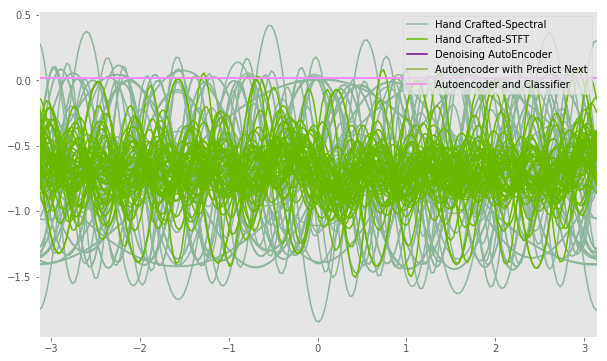

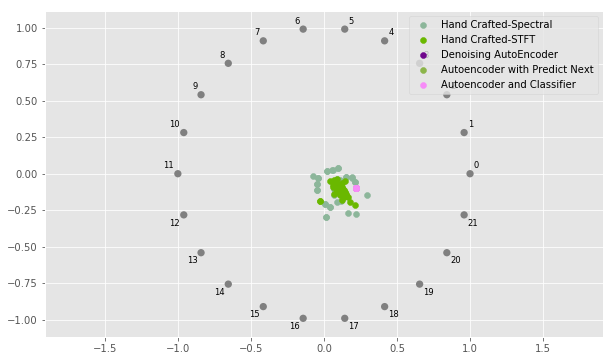

In [27]:
feature_proximity_comb_pc(mfcc_pca, df, df_grp)

0
1
2
3


feature  \
Ses01F_script01_1_F000  [[-80.0, -55.7252, -63.6822, -55.5669, -49.818...   
Ses01F_script01_1_F002  [[-44.4527, -50.9448, -56.5597, -51.0677, -53....   
Ses01F_script01_1_F003  [[-43.7314, -43.8845, -49.5323, -55.655, -51.4...   
Ses01F_script01_1_F005  [[-27.6994, -34.5879, -47.6156, -48.796, -50.7...   
Ses01F_script01_1_F006  [[-33.5538, -38.0941, -51.4969, -53.7926, -56....   
Ses01F_script01_1_F007  [[-39.3687, -49.6804, -46.557, -46.4583, -54.9...   
Ses01F_script01_1_F008  [[-59.1947, -67.0396, -54.4326, -52.6856, -53....   
Ses01F_script01_1_F009  [[-41.9292, -50.3727, -62.8463, -57.0462, -53....   
Ses01F_script01_1_F010  [[-45.0977, -48.5886, -49.9979, -51.7856, -62....   
Ses01F_script01_1_F011  [[-51.4688, -55.2357, -61.6123, -61.1923, -66....   
...                                                                   ...   
(21.0, 5.0)             [[-0.239925, 0.586654, 0.338875, 0.497245, 0.7...   
(38.0, 29.0)            [[-0.230903, 0.609276, 0.315566, 0.52438, 0.79...   
(31.0, 10.0)            [[-0.242955, 0.585178, 0.341413, 0.493946, 0.7...   
(13.0, 34.0)            [[-0.23926, 0.587416, 0.338069, 0.49836, 0.722...   
(37.0, 13.0)            [[-0.243475, 0.56859, 0.359759, 0.483048, 0.67...   
(38.0, 41.0)            [[-0.195465, 0.636241, 0.305701, 0.570221, 0.9...   
(42.0, 46.0)            [[-0.242274, 0.582664, 0.340247, 0.492248, 0.7...   
(38.0, 21.0)            [[-0.241607, 0.583097, 0.339623, 0.493081, 0.7...   
(29.0, 6.0)             [[-0.259593, 0.560365, 0.344921, 0.462027, 0.6...   
(28.0, 52.0)            [[-0.238669, 0.583458, 0.337954, 0.495585, 0.7...   

                                               cat  
Ses01F_script01_1_F000                Hand Crafted  
Ses01F_script01_1_F002                Hand Crafted  
Ses01F_script01_1_F003                Hand Crafted  
Ses01F_script01_1_F005                Hand Crafted  
Ses01F_script01_1_F006                Hand Crafted  
Ses01F_script01_1_F007                Hand Crafted  
Ses01F_script01_1_F008                Hand Crafted  
Ses01F_script01_1_F009                Hand Crafted  
Ses01F_script01_1_F010                Hand Crafted  
Ses01F_script01_1_F011                Hand Crafted  
...                                            ...  
(21.0, 5.0)             Autoencoder and Classifier  
(38.0, 29.0)            Autoencoder and Classifier  
(31.0, 10.0)            Autoencoder and Classifier  
(13.0, 34.0)            Autoencoder and Classifier  
(37.0, 13.0)            Autoencoder and Classifier  
(38.0, 41.0)            Autoencoder and Classifier  
(42.0, 46.0)            Autoencoder and Classifier  
(38.0, 21.0)            Autoencoder and Classifier  
(29.0, 6.0)             Autoencoder and Classifier  
(28.0, 52.0)            Autoencoder and Classifier  

[3049 rows x 2 columns]

min, max: 40 187575
entering pca: (3049, 187575)
after pca: (3049, 40)


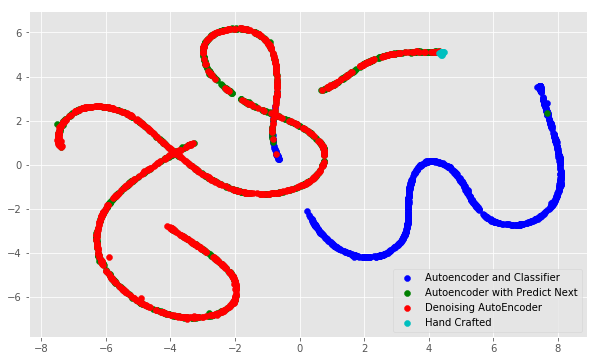

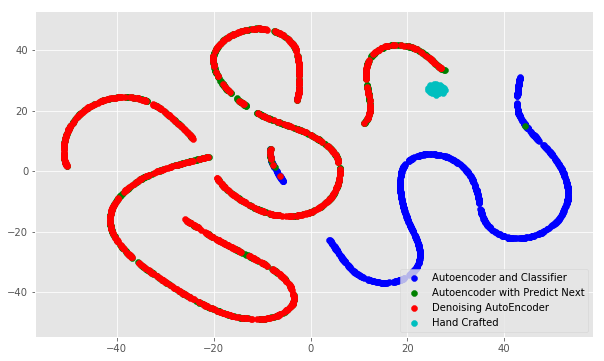

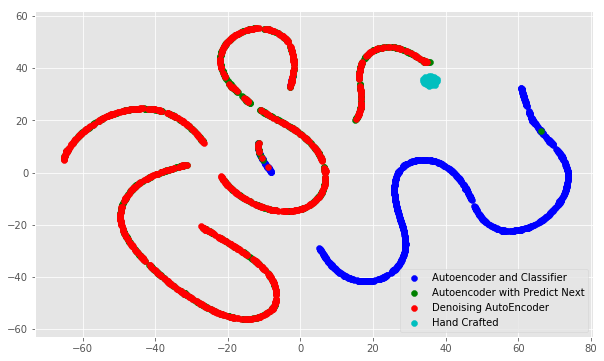

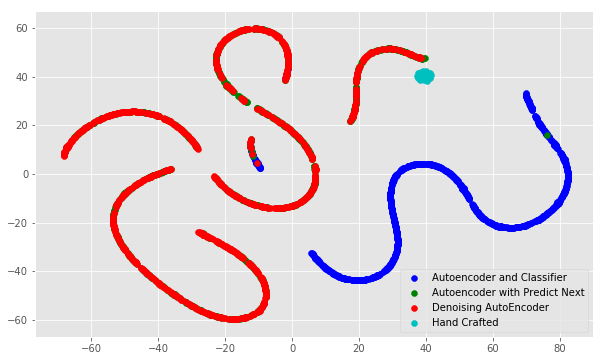

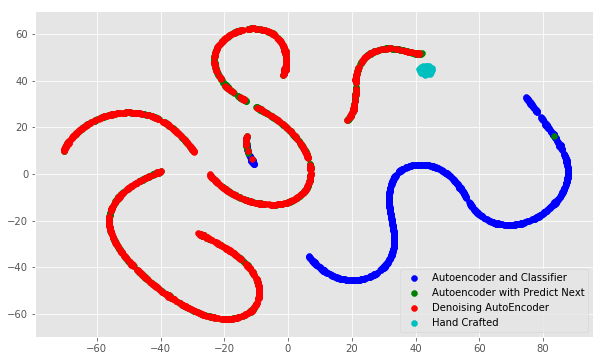

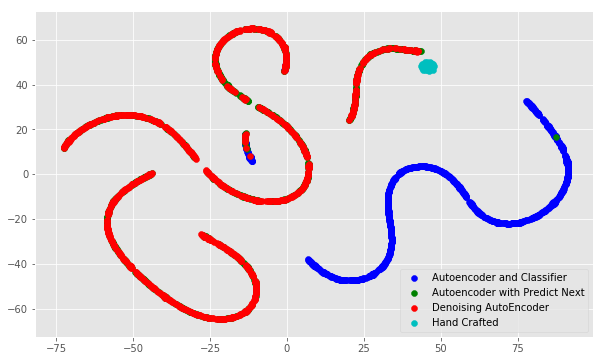

In [28]:
mfcc_pca, df, df_grp = feature_proximity_comp_tsne((x_y_sample_hand_crafted, x_y_sample_network_learned, x_y_sample_network_predictnext_learned, x_y_sample_network_targetted_learned),
                       ("mfcc", "state_c", "state_c", "hidden"), 
                       ("Hand Crafted", "Denoising AutoEncoder", "Autoencoder with Predict Next", "Autoencoder and Classifier"))

0             1             2             3             4  \
0    -0.993847 -2.947896e-02 -1.355880e-01 -1.873815e-01 -2.535798e-02   
1    -0.993847 -2.940599e-02 -2.362564e-02 -4.351898e-02 -5.717642e-02   
2    -0.993847 -2.947535e-02 -4.389324e-02 -7.598925e-02 -1.440905e-01   
3    -0.993847 -2.946883e-02 -1.077998e-01 -8.295132e-02  6.811311e-02   
4    -0.993847 -2.947002e-02  2.331592e-01  6.484973e-02  4.964115e-02   
5    -0.993847 -2.946824e-02  2.426139e-01  4.930622e-02  1.681811e-01   
6    -0.993847 -2.947406e-02 -5.745084e-02 -2.164449e-01  1.375951e-01   
7    -0.993847 -2.947301e-02  1.307610e-01 -7.322211e-02 -1.745740e-01   
8    -0.993847  6.925257e-01 -1.518648e-06 -2.763499e-06  1.336472e-06   
9    -0.993847 -2.947463e-02  5.086845e-03  5.537240e-02  6.588264e-02   
...        ...           ...           ...           ...           ...   
3039  0.016266  1.314959e-15  1.864828e-17 -9.974660e-18 -9.107298e-18   
3040  0.016264  1.308640e-15  8.673617e-18 -1.301043e-18  7.372575e-18   
3041  0.016266  1.298559e-15  1.886512e-17 -1.561251e-17  2.233456e-17   
3042  0.016266  1.304244e-15  1.301043e-17 -2.602085e-18  7.806256e-18   
3043  0.016267  1.319769e-15  9.107298e-18  5.204170e-18  1.669671e-17   
3044  0.016260  1.291524e-15  2.558717e-17 -8.239937e-18  1.170938e-17   
3045  0.016267  1.325227e-15  1.170938e-17 -5.204170e-18 -3.252607e-18   
3046  0.016267  1.316655e-15  5.421011e-18 -1.734723e-18  2.602085e-18   
3047  0.016269  1.298559e-15  0.000000e+00 -9.974660e-18 -1.105886e-17   
3048  0.016267  1.307029e-15  5.421011e-18 -6.071532e-18  3.035766e-18   

                 5             6             7             8             9  \
0     1.629012e-01 -1.440585e-01  1.568285e-01 -2.357073e-01  2.244646e-01   
1     3.670156e-01  5.813361e-03 -4.246993e-03  2.961489e-01 -8.079405e-02   
2     5.525242e-02  6.804544e-02  8.701822e-02  6.195064e-02 -9.244966e-03   
3    -1.582227e-01  3.023199e-02 -6.375686e-02 -8.307939e-02  6.996333e-02   
4    -2.680389e-01  9.664658e-02  1.932427e-01  5.740058e-02 -1.624506e-01   
5    -3.681758e-02 -1.666739e-01 -2.812264e-02 -9.161222e-02 -1.337717e-01   
6    -2.434603e-01  8.471647e-02  1.695977e-02 -2.454479e-02  8.629285e-02   
7    -2.746201e-02 -4.939333e-03 -1.894957e-01 -1.507085e-01 -1.128008e-01   
8     1.149080e-06  1.778285e-06  4.661958e-06  1.512703e-06  1.177097e-06   
9    -1.017045e-01  2.897285e-02 -2.973895e-01 -3.039597e-02 -9.320684e-02   
...            ...           ...           ...           ...           ...   
3039  8.673617e-18  1.604619e-17  8.673617e-18  1.561251e-17  1.951564e-18   
3040  4.336809e-17  9.107298e-18 -1.734723e-18  6.591949e-17 -2.818926e-18   
3041 -2.428613e-17  6.505213e-18 -8.456777e-18 -5.637851e-18  1.669671e-17   
3042 -3.295975e-17  9.974660e-18  3.252607e-18 -2.255141e-17  7.589415e-18   
3043  2.949030e-17 -1.257675e-17  8.239937e-18 -9.540979e-18  1.951564e-17   
3044 -5.204170e-18  1.344411e-17  2.602085e-18 -7.806256e-18 -4.770490e-18   
3045 -4.336809e-17  9.540979e-18  7.806256e-18 -3.426079e-17  1.582935e-17   
3046 -2.428613e-17 -2.602085e-18  3.903128e-18 -1.691355e-17  0.000000e+00   
3047 -2.949030e-17 -1.301043e-18  2.168404e-18 -1.387779e-17  9.974660e-18   
3048  2.255141e-17  1.301043e-18 -2.385245e-18  1.691355e-17 -3.903128e-18   

                 ...                        31            32            33  \
0                ...             -5.973226e-02 -1.581376e-01  2.238226e-01   
1                ...             -1.197602e-01 -3.567295e-02  6.607326e-02   
2                ...              1.188989e-01  9.582852e-02 -9.140279e-02   
3                ...             -4.987860e-02 -3.141919e-02  8.757119e-02   
4                ...             -3.007312e-02 -1.608505e-01  2.777937e-01   
5                ...              1.266902e-01  1.254595e-01 -2.101058e-01   
6                ...              2.285554e-01  1.307308e-01 -9.271355e-02   
7                ...             -1.532539e

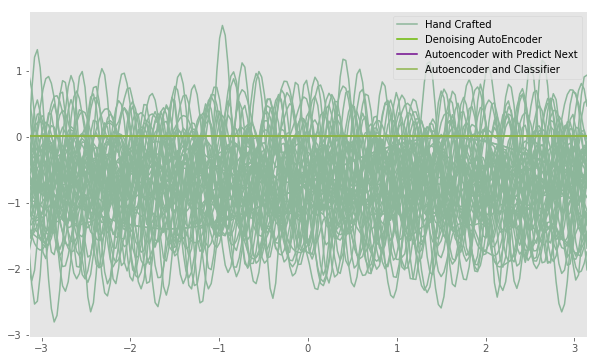

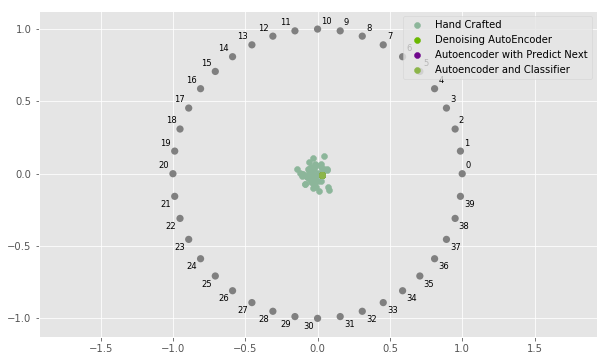

In [29]:
feature_proximity_comb_pc(mfcc_pca, df, df_grp)